---

_You are currently looking at **version 1.1** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-social-network-analysis/resources/yPcBs) course resource._

---

# Assignment 1 - Creating and Manipulating Graphs

Eight employees at a small company were asked to choose 3 movies that they would most enjoy watching for the upcoming company movie night. These choices are stored in the file `Employee_Movie_Choices.txt`.

A second file, `Employee_Relationships.txt`, has data on the relationships between different coworkers. 

The relationship score has value of `-100` (Enemies) to `+100` (Best Friends). A value of zero means the two employees haven't interacted or are indifferent.

Both files are tab delimited.

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
from networkx.algorithms import bipartite


# This is the set of employees
employees = set(['Pablo',
                 'Lee',
                 'Georgia',
                 'Vincent',
                 'Andy',
                 'Frida',
                 'Joan',
                 'Claude'])

# This is the set of movies
movies = set(['The Shawshank Redemption',
              'Forrest Gump',
              'The Matrix',
              'Anaconda',
              'The Social Network',
              'The Godfather',
              'Monty Python and the Holy Grail',
              'Snakes on a Plane',
              'Kung Fu Panda',
              'The Dark Knight',
              'Mean Girls'])


# you can use the following function to plot graphs
# make sure to comment it out before submitting to the autograder
def plot_graph(G, weight_name=None):
    '''
    G: a networkx G
    weight_name: name of the attribute for plotting edge weights (if G is weighted)
    '''
    %matplotlib notebook
    import matplotlib.pyplot as plt
    
    plt.figure()
    pos = nx.spring_layout(G)
    edges = G.edges()
    weights = None
    
    if weight_name:
        weights = [int(G[u][v][weight_name]) for u,v in edges]
        labels = nx.get_edge_attributes(G,weight_name)
        nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
        nx.draw_networkx(G, pos, edges=edges, width=weights);
    else:
        nx.draw_networkx(G, pos, edges=edges);

### Question 1

Using NetworkX, load in the bipartite graph from `Employee_Movie_Choices.txt` and return that graph.

*This function should return a networkx graph with 19 nodes and 24 edges*

In [2]:
#!cat Employee_Movie_Choices.txt

In [3]:
def answer_one():
        
    df_employee_movie = pd.read_csv('Employee_Movie_Choices.txt', sep='\t')
    G = nx.from_pandas_dataframe(df_employee_movie, '#Employee', 'Movie')
    #len(G.nodes())
    #len(G.edges())
    
    return G

<IPython.core.display.Javascript object>


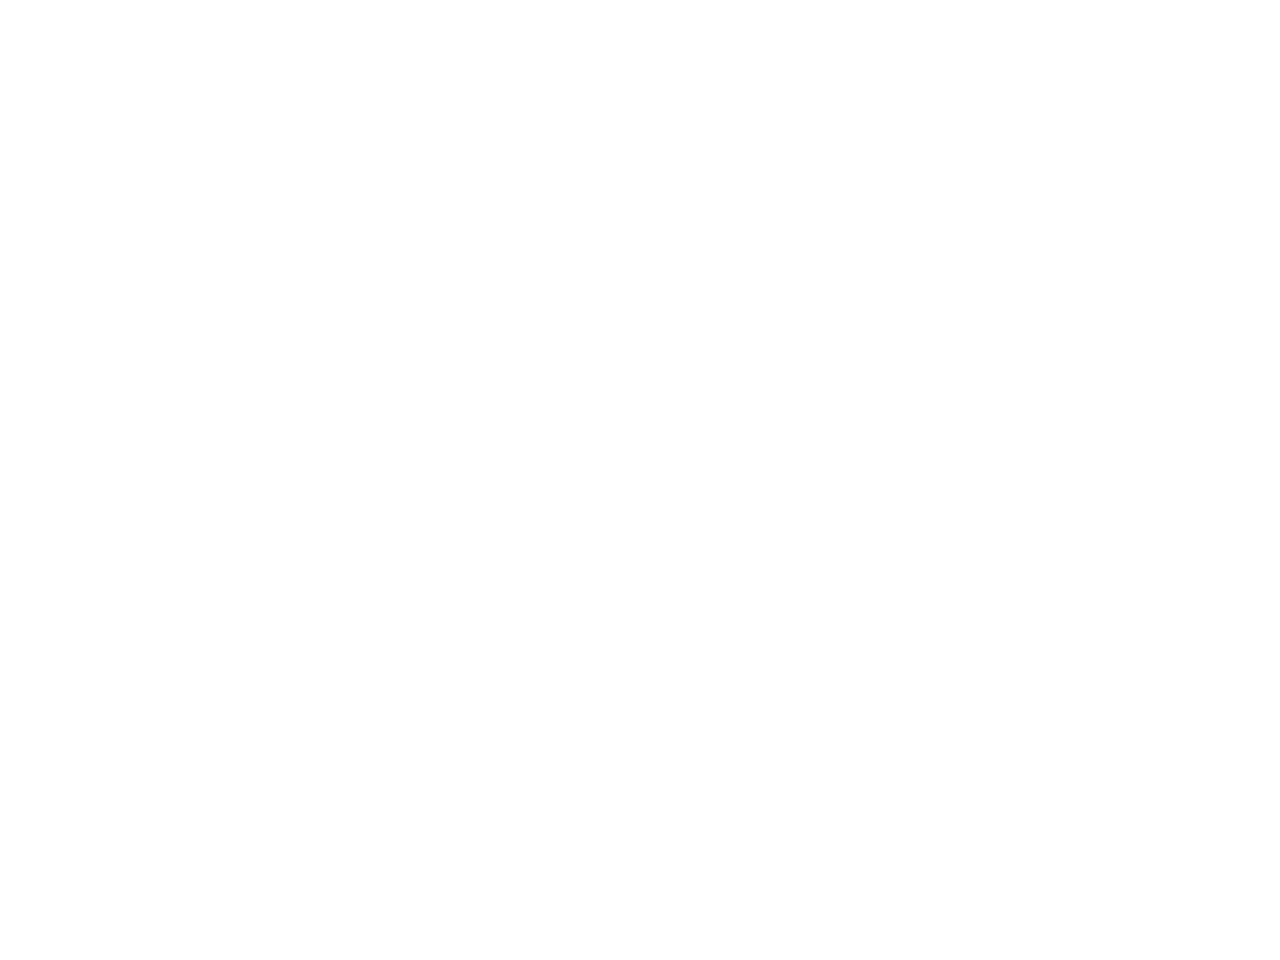

In [4]:
plot_graph(answer_one())

### Question 2

Using the graph from the previous question, add nodes attributes named `'type'` where movies have the value `'movie'` and employees have the value `'employee'` and return that graph.

*This function should return a networkx graph with node attributes `{'type': 'movie'}` or `{'type': 'employee'}`*

In [5]:
def answer_two():
    
    G = answer_one()
    for node in G.nodes():
        if node in employees:
            G.add_node(node, type="employee")
        if node in movies:
            G.add_node(node, type="movie")
    
    return G

### Question 3

Find a weighted projection of the graph from `answer_two` which tells us how many movies different pairs of employees have in common.

*This function should return a weighted projected graph.*

In [6]:
def answer_three():
    
    B = answer_two()
    P = nx.bipartite.weighted_projected_graph(B, employees)
    
    return P

<IPython.core.display.Javascript object>


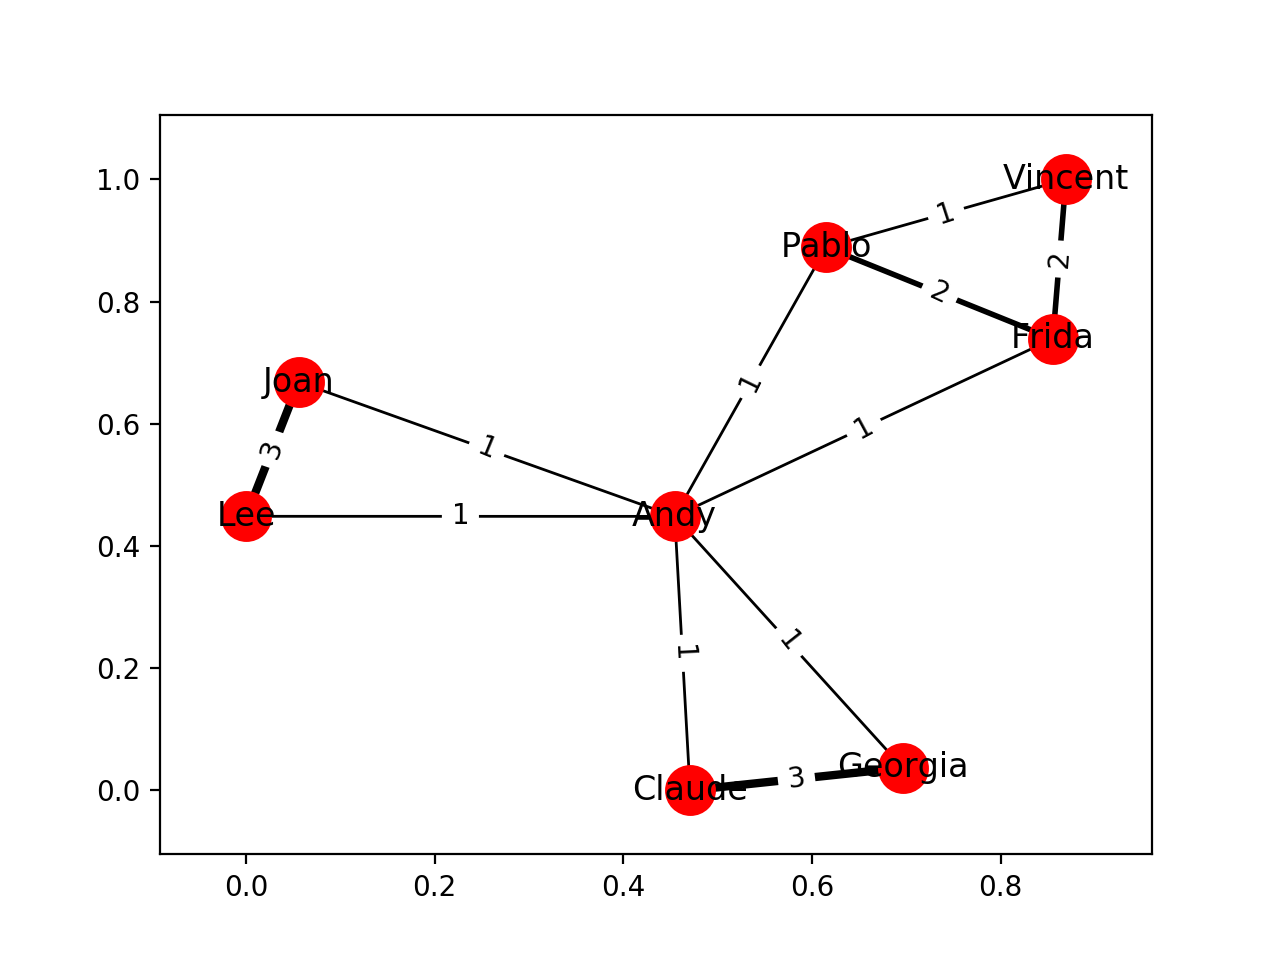

In [7]:
plot_graph(answer_three(), weight_name='weight')

### Question 4

Suppose you'd like to find out if people that have a high relationship score also like the same types of movies.

Find the Pearson correlation ( using `DataFrame.corr()` ) between employee relationship scores and the number of movies they have in common. If two employees have no movies in common it should be treated as a 0, not a missing value, and should be included in the correlation calculation.

*This function should return a float.*

In [8]:
#cat Employee_Relationships.txt

In [9]:
def answer_four():    
    
    #get projected graph: nodes are people and weight of edges is the number of common movies between them
    P = answer_three()
    #get df: Person1 | Person2 | {'weight': N}  where N is the number of common movies
    movies_in_common = pd.DataFrame(P.edges(data=True), columns=['Person1', 'Person2', 'common_movies'])
    # convert the common movies column from a dictionary to an integer
    movies_in_common['common_movies'] = movies_in_common['common_movies'].map(lambda x: x['weight'])
    
    # duplicate the movies_in_common df and switch Person1 and Person2 columns
    movies_in_common_switched = movies_in_common.copy()
    movies_in_common_switched.rename(columns={"Person1":"Person2", "Person2":"Person1"}, inplace=True)
    
    # append the swithed df to the original movies_in_common so that now we have the number of movies in common for
    # both sides of the relationship (a row Pablo|Frida|2 and another one Frida|Pablo|2)
    movies_in_common = movies_in_common.append(movies_in_common_switched)
    # reset index and drop original one (0...21 instead of 0...10-0...10)
    movies_in_common = movies_in_common.reset_index(drop=True)
    
    # get realationships df
    relationships = pd.read_csv('Employee_Relationships.txt', sep='\s', names=['Person1','Person2','relationship_score'])
    
    # merge relationships df with movies_in_common df
    complete_df = pd.merge(relationships, movies_in_common, how='left', on=['Person1', 'Person2'])
    complete_df = complete_df.fillna(value=0)
    
    # find correlation between the relationship_score and the number of common_movies
    correlation = complete_df['relationship_score'].corr(complete_df['common_movies'])
    
    return correlation